In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score

# 1. National Employment and GDP
Initially, We did some EDA on the provided data. Following are the codes and findings. 

In [2]:
employment_gdp_dataframe = pd.read_excel("./HW2_Datasets.xlsx")
employment_gdp_dataframe.head()

,Quarter,Employment (millions),GDP (billions)
0,Q1 2020,155,21500
1,Q2 2020,152,21200
2,Q3 2020,150,21700
3,Q4 2020,153,22000
4,Q1 2021,154,22200


In [3]:
employment_gdp_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Quarter                20 non-null     object
 1   Employment (millions)  20 non-null     int64 
 2   GDP (billions)         20 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 612.0+ bytes


In [4]:
employment_gdp_dataframe.describe()

,Employment (millions),GDP (billions)
count,20.000000,20.000000
mean,164.150000,23437.500000
std,9.669676,1385.818683
min,150.000000,21200.000000
25%,155.750000,22350.000000
50%,163.000000,23400.000000
75%,171.500000,24550.000000
max,181.000000,25750.000000


In [5]:
# Splitting Quarter field into years, quarter number.
employment_gdp_dataframe["Year"] = employment_gdp_dataframe["Quarter"].str[-4:].astype(int)
employment_gdp_dataframe['Quarter_num'] = employment_gdp_dataframe['Quarter'].str[1].astype(int)
employment_gdp_dataframe["Lagged Employment"] = employment_gdp_dataframe["Employment (millions)"].shift(1)
employment_gdp_dataframe = employment_gdp_dataframe.dropna()
employment_gdp_dataframe = employment_gdp_dataframe.sort_values(by= ["Year", "Quarter_num"]).reset_index().drop(columns= "index")
employment_gdp_dataframe = employment_gdp_dataframe.reset_index().rename(columns={'index': 'Coded Time'})

In [6]:
#OnehotEncoding
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output= False, drop= "first")

encoded_quarters = encoder.fit_transform(employment_gdp_dataframe[["Quarter_num"]]).astype(int)
df_encoded_quarters = pd.DataFrame(data= encoded_quarters, columns= encoder.get_feature_names_out())
df_encoded = pd.concat([employment_gdp_dataframe, df_encoded_quarters], axis= 1)
df_encoded.head()

,Coded Time,Quarter,Employment (millions),GDP (billions),Year,Quarter_num,Lagged Employment,Quarter_num_2,Quarter_num_3,Quarter_num_4
0,0,Q2 2020,152,21200,2020,2,155.0,1,0,0
1,1,Q3 2020,150,21700,2020,3,152.0,0,1,0
2,2,Q4 2020,153,22000,2020,4,150.0,0,0,1
3,3,Q1 2021,154,22200,2021,1,153.0,0,0,0
4,4,Q2 2021,156,22400,2021,2,154.0,1,0,0


In [7]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Coded Time             19 non-null     int64  
 1   Quarter                19 non-null     object 
 2   Employment (millions)  19 non-null     int64  
 3   GDP (billions)         19 non-null     int64  
 4   Year                   19 non-null     int64  
 5   Quarter_num            19 non-null     int64  
 6   Lagged Employment      19 non-null     float64
 7   Quarter_num_2          19 non-null     int64  
 8   Quarter_num_3          19 non-null     int64  
 9   Quarter_num_4          19 non-null     int64  
dtypes: float64(1), int64(8), object(1)
memory usage: 1.6+ KB


In [8]:
# Multivariate linear regression model
X_train = df_encoded.drop(columns= ["Quarter", "GDP (billions)", "Employment (millions)", "Quarter_num", "Coded Time"])
y_train = df_encoded[["GDP (billions)"]]
X_train_with_const = sm.add_constant(X_train)

multivariate_ols_model = sm.OLS(y_train, X_train_with_const).fit()

In [9]:
y_predicted_multivariiate = multivariate_ols_model.predict(X_train_with_const)
print(f"Mean_squared error for multivariate linear regression: {mean_squared_error(y_true= y_train, y_pred= y_predicted_multivariiate)}")

Mean_squared error for multivariate linear regression: 2961.873985624827


In [10]:
#Univariate linear regression model
X_train_univariate = df_encoded[["Lagged Employment"]]

X_train_univariate_with_const = sm.add_constant(X_train_univariate)

univariate_ols_model = sm.OLS(y_train, X_train_univariate_with_const).fit()

In [11]:
y_predicted_univariiate = univariate_ols_model.predict(X_train_univariate_with_const)
print(f"Mean_squared error for univariate linear regression: {mean_squared_error(y_true= y_train, y_pred= y_predicted_univariiate)}")

Mean_squared error for univariate linear regression: 88189.44444027875


### Residual Scatterplot: Create a scatterplot of the residuals against the lagged employment.

=> We created the residual scatter plots using multivariate linear regression and univariate linear regression. In multivariate linear regression, we used Year, Lagged Employment and one hot encoded quarter numbers. For Univariate linear regression, We only used Lagged Employment as the predictor and "GDP (Billions)" as dependent variable. 

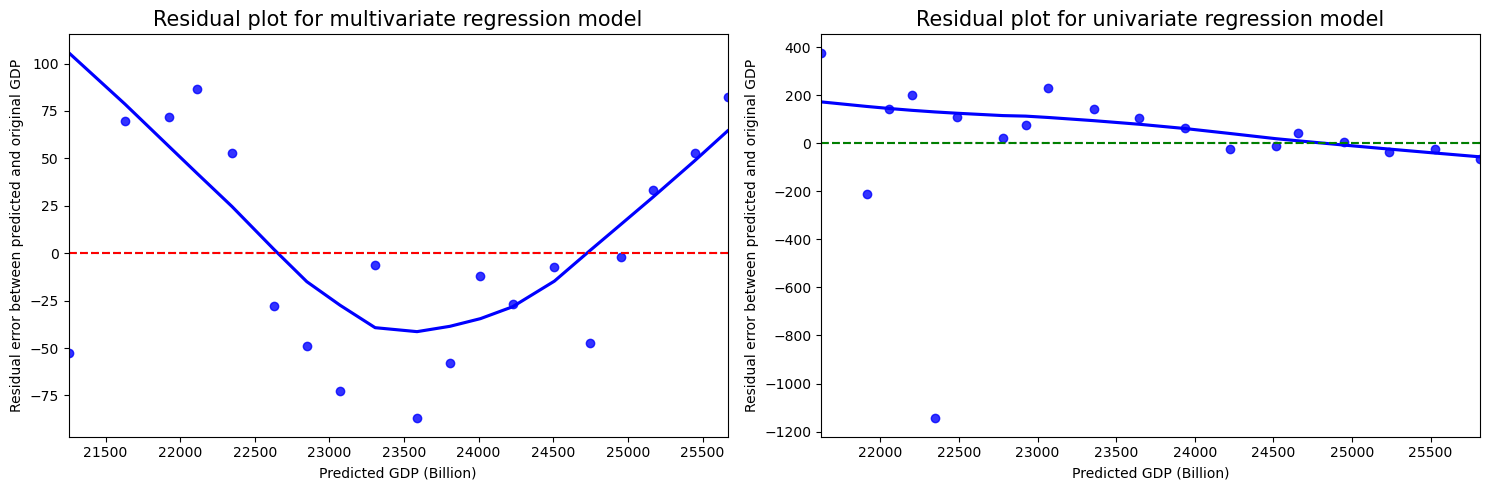

In [12]:
fig, axs = plt.subplots(1, 2, figsize= (15, 5))

sns.residplot(x = y_predicted_multivariiate, y = multivariate_ols_model.resid, lowess=True, color='blue', ax= axs[0])
axs[0].axhline(0, color='red', linestyle='--')
axs[0].set_xlabel("Predicted GDP (Billion)")
axs[0].set_ylabel("Residual error between predicted and original GDP")
axs[0].set_title("Residual plot for multivariate regression model", fontsize = 15)

sns.residplot(x = y_predicted_univariiate, y = univariate_ols_model.resid, lowess=True, color='blue', ax= axs[1])
axs[1].axhline(0, color='green', linestyle='--')
axs[1].set_xlabel("Predicted GDP (Billion)")
axs[1].set_ylabel("Residual error between predicted and original GDP")
axs[1].set_title("Residual plot for univariate regression model", fontsize = 15)

plt.tight_layout()
plt.show()

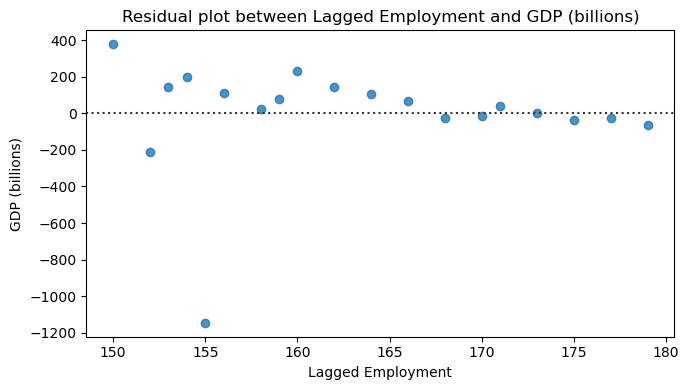

In [13]:
plt.figure(figsize=(7, 4))
sns.residplot(y = "GDP (billions)", x = "Lagged Employment", data= df_encoded)
plt.title("Residual plot between Lagged Employment and GDP (billions)")
plt.tight_layout()
plt.show()

### Does the plot suggest that the residuals are homoscedastic?
As we can see the residual plots for both univariate and multivariate linear regressions, residual plot does not lie within the specific width around the x-axis. Residuals are randomly scattered around the horizontal axis with no clear pattern. Hence, the residuals are not homoscedastic for both univariate and multivariate linear regressions. 

### Residual Histogram: Create a histogram of the residuals and compare it to the normal distribution

=> We plotted the histogram for the residuals from both univariate linear regression and multivariate linear regression. Below is the code and plot generated. 

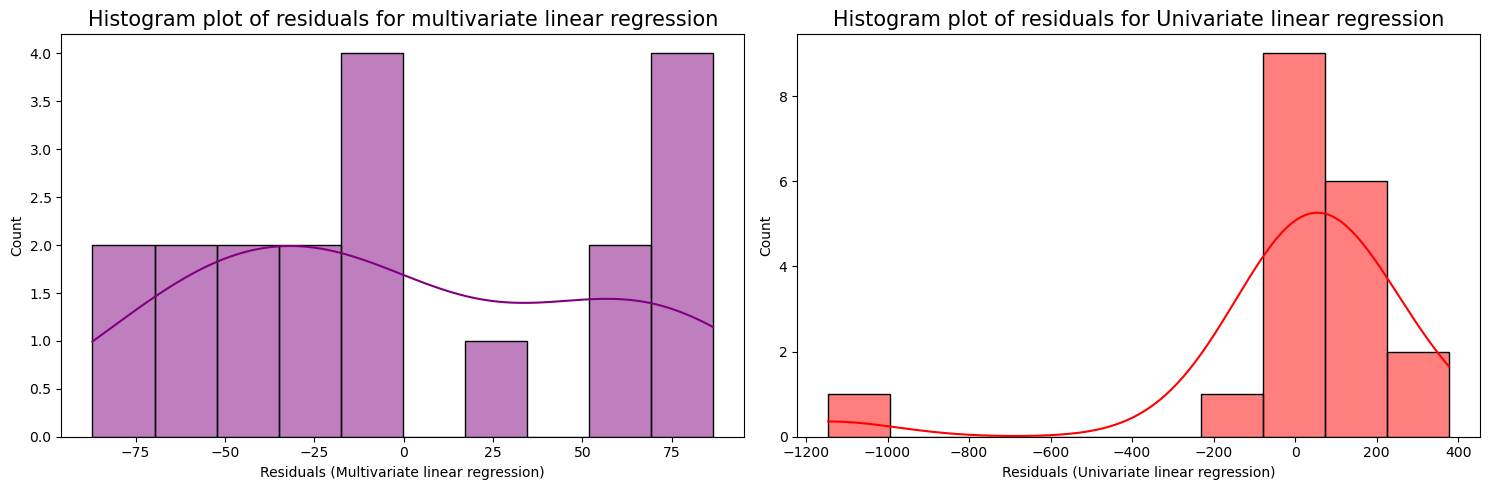

In [14]:
fig, axs= plt.subplots(1, 2, figsize= (15, 5))

sns.histplot(data= multivariate_ols_model.resid,  kde= True,bins=10, color='purple', ax= axs[0])
axs[0].set_xlabel("Residuals (Multivariate linear regression)", fontsize = 10)
axs[0].set_title("Histogram plot of residuals for multivariate linear regression", fontsize = 15)

sns.histplot(data= univariate_ols_model.resid,  kde= True,bins=10, color='red', ax= axs[1])
axs[1].set_xlabel("Residuals (Univariate linear regression)", fontsize = 10)
axs[1].set_title("Histogram plot of residuals for Univariate linear regression", fontsize = 15)

plt.tight_layout()
plt.show()

### Are the residuals approximately normally distributed? Why or why not? 

=> No, the residuals from both univariate linear regression and multivariate linear regression are not normally distributed because we we can see in figures plotted above, there is shape of both histogram plots are not resembled with the normal distribution plot. 

In [15]:
multivariate_ols_model.summary()

/home/buddha-thapa-magar/anaconda3/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  res = hypotest_fun_out(*samples, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         GDP (billions)   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     1501.
Date:                Sun, 10 Nov 2024   Prob (F-statistic):           1.80e-17
Time:                        16:37:08   Log-Likelihood:                -102.90
No. Observations:                  19   AIC:                             217.8
Df Residuals:                      13   BIC:                             223.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -2.148e+06   1.18e+05    -18.185      0.000    -2.4e+06   -1.89e+06
Year               1075.1900     59.122     18.186      0.000     947.465    1202.915
Lagged Employment   -19.3557      9.134     -2.119      0.054     -39.089       0.377
Quarter_num_2       253.3205     51.444      4.924      0.000     142.183     364.458
Quarter_num_3       572.6762     56.585     10.121      0.000     450.432     694.921
Quarter_num_4       832.0319     62.643     13.282      0.000     696.700     967.364
==============================================================================
Omnibus:                        3.870   Durbin-Watson:                   0.790
Prob(Omnibus):                  0.144   Jarque-Bera (JB):                1.443
Skew:                           0.194   Prob(JB):                        0.486
Kurtosis:                       1.707   Cond. No.                     1.59e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.59e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [16]:
univariate_ols_model.summary()

/home/buddha-thapa-magar/anaconda3/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  res = hypotest_fun_out(*samples, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         GDP (billions)   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     313.1
Date:                Sun, 10 Nov 2024   Prob (F-statistic):           2.19e-12
Time:                        16:37:08   Log-Likelihood:                -135.14
No. Observations:                  19   AIC:                             274.3
Df Residuals:                      17   BIC:                             276.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -55.0648   1335.336     -0.041      0.968   -2872.378    2762.249
Lagged Employment   144.5184      8.167     17.695      0.000     127.287     161.750
==============================================================================
Omnibus:                       35.615   Durbin-Watson:                   0.803
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               87.870
Skew:                          -2.871   Prob(JB):                     8.30e-20
Kurtosis:                      11.833   Cond. No.                     3.03e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.03e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Significance Test: At the .05 significance level, does employment in the previous quarter significantly influence GDP? Support your answer using the regression output. 

- Univariate linear regression: \
=> If we look into the p-value of the "Lagged Employment", it has the value of 0 which is less than 0.05. It signifies that "Lagged Employment" has significance in determining the "GDP (Billions)". 

- Multivariate linear regression: \
=> If we look into the p-value of the "Lagged Employment", it has the value of 0.054 which is greater than 0.05. It means that "Lagged Employment" has less significance in determining the "GDP(Billions)" when comparing with other predictors. 

### Variation Explained: What percentage of the variation in GDP is explained by employment in the previous quarter? 
- Univariate Linear Regression: \
=> While looking into the R-squared value, it has value of 0.949. This means Employment in the previous quarter can explain the 94.9% of variation in GDP. 

- Multivariate Linear Regression: \
=> It has R-square value of 0.998. This means 99.8 % of the variation in GDP is explained by predictors. Predictors are "Year", "Lagged Employment", "One hot encoded quarters". But, "Lagged Employment" has the higher p-value among all predictors.

### Impact of Employment Increase: Estimate the change in quarterly GDP for a 1 million increase in employment. 
- Univariate linear regression: \
=> We only have "Lagged Employment" as the predictors. Lagged Employment is in Millions and GDP is in billion. It has the coefficient of around 144.5. This means for 1 million increase in employment, there will be 144.5 billion increase in GDP. 
- Multivariate linear regression: \
=> We have "Year", "Lagged Employment (Millions)", and One hot encoded quarters as predictors. GDP is in billion. "Lagged Employment" has the coefficient of around -19.35. This means they have inverse associations. 1 Million increase in employment leads to 19.35 billion decrease in GDP. 

# 2. Smartwatch_Pricing

Initially, We perform EDA and prepared multivariate linear regression model.

In [17]:
smartwatch_price_df = pd.read_excel("./HW2_Datasets.xlsx", sheet_name= "Smartwatch_Pricing")
smartwatch_price_df.head()

,Price (USD),Battery Life (hours),Display Quality (1-5),Water Resistance (meters)
0,250,24,4,50
1,200,18,3,30
2,300,30,5,100
3,150,16,3,20
4,400,36,5,150


In [18]:
smartwatch_price_df.describe()

,Price (USD),Battery Life (hours),Display Quality (1-5),Water Resistance (meters)
count,20.000000,20.000000,20.000000,20.000000
mean,298.000000,27.600000,3.850000,78.250000
std,89.639629,7.315449,0.988087,46.205348
min,140.000000,15.000000,2.000000,10.000000
25%,242.500000,21.750000,3.000000,38.750000
50%,297.500000,28.500000,4.000000,70.000000
75%,367.500000,33.250000,5.000000,112.500000
max,430.000000,40.000000,5.000000,160.000000


In [19]:
smartwatch_price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   Price (USD)                20 non-null     int64
 1   Battery Life (hours)       20 non-null     int64
 2   Display Quality (1-5)      20 non-null     int64
 3   Water Resistance (meters)  20 non-null     int64
dtypes: int64(4)
memory usage: 772.0 bytes


In [20]:
X_train_sw = smartwatch_price_df.drop(columns= ["Price (USD)"])
y_train_sw = smartwatch_price_df[["Price (USD)"]]

X_train_sw_with_const = sm.add_constant(X_train_sw)

sw_ols_model = sm.OLS(y_train_sw, X_train_sw_with_const).fit()

In [21]:
sw_ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Price (USD)   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     65.52
Date:                Sun, 10 Nov 2024   Prob (F-statistic):           3.32e-09
Time:                        16:37:08   Log-Likelihood:                -91.915
No. Observations:                  20   AIC:                             191.8
Df Residuals:                      16   BIC:                             195.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                       -80.8143     56.929     -1.420      0.175    -201.499      39.870
Battery Life (hours)         12.9974      3.057      4.252      0.001       6.518      19.477
Display Quality (1-5)        13.2338      8.426      1.571      0.136      -4.629      31.096
Water Resistance (meters)    -0.3944      0.512     -0.771      0.452      -1.479       0.690
==============================================================================
Omnibus:                        1.532   Durbin-Watson:                   2.622
Prob(Omnibus):                  0.465   Jarque-Bera (JB):                1.186
Skew:                           0.388   Prob(JB):                        0.553
Kurtosis:                       2.095   Cond. No.                         901.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Model Significance: Is the overall model significant at the 0.05 level? Explain your reasoning.
=> F-statistic signifies the overall model significant. For out multivariate linear regression model, It has F-statistics value of $3.32 * 10^{-9}$ which is much smaller than 0.05. This means overall model has significance at the 0.05 level. 

### Predicted Price: Use the model to predict the price of the new smartwatch
Tech Innovate expects their new product to have 20 hours of battery life, a display quality of 4, and 30 meters of water resistance.\
We predict the price of the new product by using the linear regression model we trained. 

In [22]:
new_smartwatch_with_const = pd.DataFrame({
    "const": [1],
    "Battery Life (hours)": [20],
    "Display Quality (1-5)": [4],
    "Water Resistance (meters)": [30]
})

new_sw_predicted_price = sw_ols_model.predict(new_smartwatch_with_const)

print(f"Predicted price for the new smartwatch: ${new_sw_predicted_price.iloc[0]:.2f}")

Predicted price for the new smartwatch: $220.24


### Significant Drivers: Based on the model, which factors are significant drivers of price? Are there any variables that seem counterintuitive? 

<table>
  <tr>
    <th>Variable</th>
    <th>coef</th>
    <th>std err</th>
    <th>t</th>
    <th>P>|t|</th>
  </tr>
  <tr>
    <td>const</td>
    <td>-80.8143</td>
    <td>56.929</td>
    <td>-1.420</td>
    <td>0.175</td>
  </tr>
  <tr>
    <td>Battery Life (hours)</td>
    <td>12.9974</td>
    <td>3.057</td>
    <td>4.252</td>
    <td>0.001</td>
  </tr>
  <tr>
    <td>Display Quality (1-5)</td>
    <td>13.2338</td>
    <td>8.426</td>
    <td>1.571</td>
    <td>0.136</td>
  </tr>
  <tr>
    <td>Water Resistance (meters)</td>
    <td>-0.3944</td>
    <td>0.512</td>
    <td>-0.771</td>
    <td>0.452</td>
  </tr>
</table>

As we can see in the table above, "Battery Life (hours)" has least p-value which means it is the most significant factor while determining variance in price. After that, "Display Quality" has the moderate significance and "Water Resistance (meters)" has least significance. \
\
While looking into the coefficients of 3 predictors, 
- "Battery Life (hours)" and "Display Quality (1-5)" has positive coefficient values. This means whenever battery life or display quality increases, it increases the price of the watch. 
- But, "Water Resistance (meters)" has negative coefficient. It is the counterintuitive variable. whenever, water resistance increases, it tends to decrease the price of watch. 

### Correlation Analysis: Check for multicollinearity by calculating the correlations between the drivers. Which pairs of variables show a strong correlation? 

In [23]:
# Price field dropped as we are trying to check multicollinearity among predictors
sw_correlation_matrix = smartwatch_price_df.drop(columns= ["Price (USD)"]).corr()
sw_correlation_matrix

,Battery Life (hours),Display Quality (1-5),Water Resistance (meters)
Battery Life (hours),1.000000,0.617456,0.960879
Display Quality (1-5),0.617456,1.000000,0.668344
Water Resistance (meters),0.960879,0.668344,1.000000


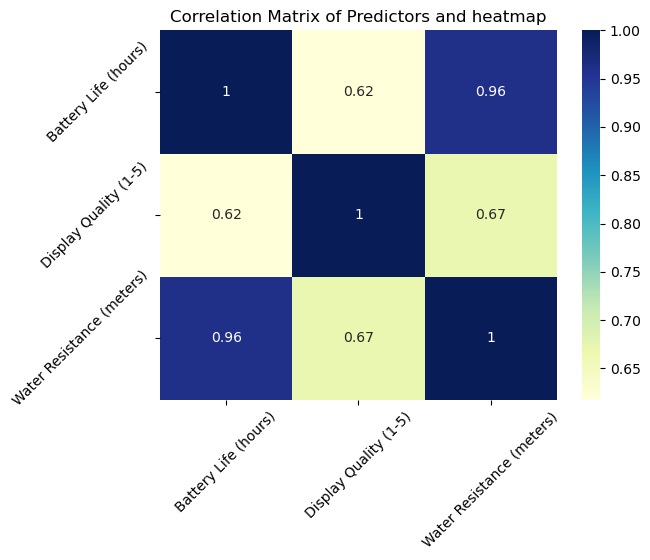

In [24]:
sns.heatmap(data= sw_correlation_matrix, annot= True, cmap= "YlGnBu")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.title('Correlation Matrix of Predictors and heatmap')
plt.show()

According to the above correlation matrices, it is found that 
- battery life and water resistance has the maximum correlation coefficient of 0.96. It means there is strong association and collinearity between "Battery Life (hours)" and "Water Resistance (meter)". 

### Revised Model: If necessary, remove any highly correlated drivers and rerun the regression. Has the model improved? 
=> As we can see, there is high correlation between "Battery Life (hours)" and "Water Resistance (meter)", we will be removing "Water Resistance (meter)" from predictors and preparing new linear regression model. 

In [25]:
new_X_train_sw = smartwatch_price_df.drop(columns= ["Price (USD)", "Water Resistance (meters)"])

new_X_train_sw_with_const = sm.add_constant(new_X_train_sw)

new_sw_ols_model = sm.OLS(y_train_sw, new_X_train_sw_with_const).fit()

In [26]:
new_sw_ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Price (USD)   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     100.4
Date:                Sun, 10 Nov 2024   Prob (F-statistic):           3.85e-10
Time:                        16:37:08   Log-Likelihood:                -92.280
No. Observations:                  20   AIC:                             190.6
Df Residuals:                      17   BIC:                             193.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -42.1472     26.583     -1.585      0.131     -98.233      13.939
Battery Life (hours)     10.7902      1.056     10.222      0.000       8.563      13.017
Display Quality (1-5)    10.9969      7.815      1.407      0.177      -5.492      27.486
==============================================================================
Omnibus:                        1.555   Durbin-Watson:                   2.494
Prob(Omnibus):                  0.460   Jarque-Bera (JB):                1.287
Skew:                           0.464   Prob(JB):                        0.525
Kurtosis:                       2.172   Cond. No.                         130.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Yes, Removing the highly correlated predictor (In this case Water Resistance) has improved the model.

Newly trained linear regression model has the performance similar to original model. 
- New model has R-squared value of 0.922 which mean Battery life and Display quality can explain the 92.2% variance in price. But in old model, there is 0.925 R-squared value which mean Battery life, Display quality and Water Resistance (meters) 92.5% variance in price. 
- If we look into the adjusted R-squared value of both old model and new model, new model has higher adjusted R-squared value of 0.913 in comparision with old model which has adjusted R-squared value of 0.911. This mean, removing water resistance variable as predictor actually improves the predictive ability of the model.